In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

### Loading Data

In [3]:
import numpy as np

In [4]:
english = np.load("/content/drive/My Drive/Colab Notebooks/English_text.npy")
hindi   = np.load("/content/drive/My Drive/Colab Notebooks/Hindi_text.npy")

In [5]:
print (english[0])
print (hindi[0])

wow
वाह


### Defining Encoder and Decoder inputs/Outpus

In [6]:
input_sentences = []
for i in range(len(english)):
    input_sentences.append(english[i])

In [7]:
output_sentences_inputs = []
for i in range(len(hindi)):
    temp = hindi[i]
    temp = '<sos> ' + temp
    output_sentences_inputs.append(temp)

In [8]:
output_sentences = []
for i in range(len(hindi)):
    temp = hindi[i]
    temp = temp + ' <eos>'
    output_sentences.append(temp)

### Tokenizing

In [9]:
from keras.preprocessing.text import Tokenizer

In [10]:
# Tokenizing Engish Text
tokenizer_encoder = Tokenizer(filters = '')
tokenizer_encoder.fit_on_texts(english)
Encoder_input = tokenizer_encoder.texts_to_sequences(english)

In [11]:
# Tokenizing Hindi_input Text
tokenizer_decoder = Tokenizer(filters = '')
tokenizer_decoder.fit_on_texts(output_sentences_inputs+output_sentences)
Decoder_input = tokenizer_decoder.texts_to_sequences(output_sentences_inputs)

In [12]:
# Tokenizing Hindi_output Text
Decoder_output = tokenizer_decoder.texts_to_sequences(output_sentences)

In [13]:
word2idx_outputs = tokenizer_decoder.word_index
num_words_output = len(word2idx_outputs) + 1
print ("Number of words in Output is: ", num_words_output)

Number of words in Output is:  2969


### Padding

In [14]:
from keras.preprocessing.sequence import pad_sequences

In [15]:
English = pad_sequences(Encoder_input, padding ='post')
print("Encoder_data.shape:", English.shape)

Encoder_data.shape: (2773, 23)


In [16]:
Hindi_input = pad_sequences(Decoder_input, padding ='post')
print("Decoder_data.shape:", Hindi_input.shape)

Decoder_data.shape: (2773, 26)


In [17]:
Hindi_output = pad_sequences(Decoder_output, padding ='post')
print("Decoder_data.shape:", Hindi_output.shape)

Decoder_data.shape: (2773, 26)


In [18]:
max_len_input = 23
max_len_output = 26

### Loading Pre-trained word vectors

In [19]:
import numpy as np

In [22]:
word2vec = {}                                                     # Dictionary for word 2 vector mapping
with open('/content/drive/My Drive/Colab Notebooks/glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()                                     # Reading Line
        word = values[0]                                          # First part of line is word
        vec = np.asarray(values[1:], dtype='float32')             # Second part of line is Vector
        word2vec[word] = vec                                      # Creating dictionary


### Preparing Embedding Matrix

In [23]:
word2idx_inputs = tokenizer_encoder.word_index
num_words = len(word2idx_inputs) + 1                         
embedding_matrix = np.zeros((num_words, 50))
for word, i in word2idx_inputs.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix.shape

(2305, 50)

### Creating Embedding Layer

In [25]:
from keras.layers import Embedding

In [26]:
embedding_layer = Embedding(num_words, 
                            50, 
                            weights=[embedding_matrix], 
                            input_length=max_len_input)

### Making Decoder Targets

In [27]:
decoder_targets_one_hot = np.zeros((
                                    len(input_sentences),
                                    max_len_output,
                                    num_words_output
                                    ),
                                    dtype = 'float32')

In [28]:
decoder_targets_one_hot.shape

(2773, 26, 2969)

In [29]:
# Inserting values in Targets
for i, d in enumerate(Hindi_output):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### Building Model

In [30]:
from keras.layers import Input, LSTM, Bidirectional, Dense

#### Building Encoder

In [31]:
# Input Layer
encoder_inputs_placeholder = Input(shape=(max_len_input,))
# Embedding Layer
x = embedding_layer(encoder_inputs_placeholder)
# LSTM Layer
encoder = LSTM(512, return_state=True)
encoder_outputs, h, c = encoder(x)
# Encoder Output Layer
encoder_states = [h, c]

#### Building Decoder

In [32]:
# Input layer
decoder_inputs_placeholder = Input(shape=(max_len_output,))
# Embedding Layer
decoder_embedding = Embedding(num_words_output, 50)                   # Creating
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)      # Passing
# LSTM Layer
decoder_lstm = LSTM(512,return_sequences=True,return_state=True,)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x,initial_state=encoder_states)
# Hidden Layer
decoder_dense = Dense(num_words_output, activation='softmax')
# Decoder Output Layer
decoder_outputs = decoder_dense(decoder_outputs)

#### Defining Model

In [33]:
from keras.models import Model

In [34]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder],   # Inputs
              decoder_outputs)                                           # Outputs

### Compiling Model

In [35]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training Model

In [36]:
r = model.fit(
    [English, Hindi_input],
    decoder_targets_one_hot,
    batch_size=20,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
125/125 [==============================] - 3s 25ms/step - loss: 1.9100 - accuracy: 0.7255 - val_loss: 3.1045 - val_accuracy: 0.5451
Epoch 2/30
125/125 [==============================] - 2s 20ms/step - loss: 1.5657 - accuracy: 0.7603 - val_loss: 2.9716 - val_accuracy: 0.5844
Epoch 3/30
125/125 [==============================] - 2s 20ms/step - loss: 1.4744 - accuracy: 0.7683 - val_loss: 2.8730 - val_accuracy: 0.5924
Epoch 4/30
125/125 [==============================] - 2s 20ms/step - loss: 1.4105 - accuracy: 0.7743 - val_loss: 2.7902 - val_accuracy: 0.5975
Epoch 5/30
125/125 [==============================] - 2s 20ms/step - loss: 1.3474 - accuracy: 0.7804 - val_loss: 2.8000 - val_accuracy: 0.5989
Epoch 6/30
125/125 [==============================] - 2s 20ms/step - loss: 1.2898 - accuracy: 0.7849 - val_loss: 2.7510 - val_accuracy: 0.6064
Epoch 7/30
125/125 [==============================] - 3s 20ms/step - loss: 1.2346 - accuracy: 0.7900 - val_loss: 2.7506 - val_accuracy: 0.6040

### Visualizing Results

In [38]:
import matplotlib.pyplot as plt


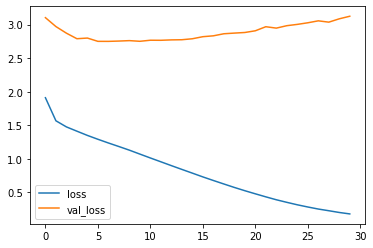

In [39]:
# Loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig('Loss.png')
plt.show()

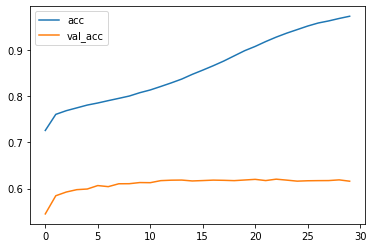

In [40]:
# Accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

### Saving the Model

In [41]:
model.save('Machine_Translation_using_Seq2Seq.h5')

### Building Model for Prediction

#### Encoder Model

In [42]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

#### Decoder Model

In [43]:
# Input Layer
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c = Input(shape=(512,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# Input Layer for single work
decoder_inputs_single = Input(shape=(1,))
# Embedding Layer
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
# LSTM Layer
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
# Output Layer
decoder_outputs = decoder_dense(decoder_outputs)

### Defining Model

In [44]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

### Vector -> Word

In [45]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

### Prediction Function

In [52]:
def translate_sentence(input_seq):
    # Encoder Prediction
    states_value = encoder_model.predict(input_seq)
    # Starting of Target Sentence
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    # Target Sentence
    output_sentence = []

    # Loop for detecting words
    for _ in range(max_len_output):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        
        # Break when target sentence finished
        if eos == idx:
            break

        word = ''
        
        # Adding Word to the prediction sentence
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        
        # States for next word
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

### Translation

In [56]:
while True:
  # Do some test translations
  i = np.random.choice(len(English))
  input_seq = English[i:i+1]
  translation = translate_sentence(input_seq)
  print('-')
  print('Input:', english[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: i did not want this to happen
Translation: मैं नहीं चाहता था कि ऐसा हो।
Continue? [Y/n]y
-
Input: a rabbit has long ears
Translation: खरगोश के कान लम्बे होते हैं।
Continue? [Y/n]y
-
Input: i was amazed at the speed of the car
Translation: मैं उस गाड़ी की रफ़तार देखकर हैरान रह गया।
Continue? [Y/n]y
-
Input: come along with us
Translation: हमारे साथ आओ।
Continue? [Y/n]y
-
Input: he went there instead of me
Translation: वह मेरे बजाय गया।
Continue? [Y/n]n
